# **Introduction Dataset**


Dataset kelompokan ke dalam 3 folder (train, test, val) dan berisi subfolder untuk setiap kategori gambar (Pneumonia/Normal). Dengan total 5.863 gambar X-Ray (JPEG) dan 2 kategori (Pneumonia/Normal) Parameter yang dihitung adalah tingkat akurasi,loss dari model, kemudian tingkat evaluasi dari model.

### **Sumber Dataset**
https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

## **Langkah-Langkah Pengerjaan:**
1. Loading and understanding data
2. Data Visualization
3. Data Preprocessing
4. Model Building
5. Model Evaluation

# **1. Loading and understanding data**

In [ ]:
# Importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
import os
!pip install tensorflow==2.1.0
!pip install keras==2.3.1
from keras.models import Sequential, load_model, Model
%matplotlib inline

warnings.simplefilter(action='ignore')
plt.style.use('seaborn')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Melakukan Ektraksi Gambar dan Menyimpan dalam bentuk list**

In [ ]:
import zipfile

def path_extractor(zipPATH,zip_file,trgt_dir):
  # Ekstraksi Konten
  if 'chest_xray' not in os.listdir('.'):
    with zipfile.ZipFile(zipPATH+zip_file,"r") as z:
            print(f"Extracting content from {zip_file} ......")
            z.extractall()
            print(f"Extracted to {os.getcwd()}")
  # Menyimpan gambar kedalam list
  paths = [] 
  cls_labels = [] 
  print(f"Reading image paths in chest_xray/{trgt_dir} directory")
  folder = "."+os.path.sep+'chest_xray'+os.path.sep+trgt_dir
  print(f'Available classes {os.listdir(folder)}')
  for root, dirs, files in os.walk(folder):
      for file in files:
        if file.endswith(".jpeg"):
          f_path = os.path.join(root, file)
          label = f_path.split('/')[-2]
          cls_labels.append(label)
          paths.append(f_path)
  print("DONE")
  return paths,cls_labels

In [ ]:
# Path lokasi dataset di dalam drive
PATH = "/content/drive/MyDrive/Colab Notebooks/dataset/"
zip_file = "archive.zip"

trainImg_paths, y_train = path_extractor(PATH,zip_file,trgt_dir="train")
testImg_paths, y_test = path_extractor(PATH,zip_file,trgt_dir="test")

Reading image paths in chest_xray/train directory


FileNotFoundError: ignored

**Membaca list gambar untuk menghasilkan preposesing Image**

In [ ]:
import cv2

IMAGE_SIZE = (150,150)

def images_extractor(paths):

  images = []
  for path in paths:
    currImg_BGR = cv2.imread(path)
    b,g,r = cv2.split(currImg_BGR)
    currImg_RGB = cv2.merge([r,g,b])
    currImg = cv2.resize(currImg_RGB,IMAGE_SIZE)
    images.append(currImg)
  return images

**Membuat Split data untuk Data Training dan Testing**

In [ ]:
#Array untuk Train Image 
X_train = images_extractor(trainImg_paths)
X_train = np.array(X_train)
y_train = np.array(y_train)
print("Shape of train set",X_train.shape)
print("Number of train samples",len(X_train))

Shape of train set (5216, 150, 150, 3)
Number of train samples 5216


In [ ]:
#Array untuk Test Image
X_test = images_extractor(testImg_paths)
X_test = np.array(X_test)
y_test = np.array(y_test)
print("Shape of test set",X_test.shape)
print("Number of test samples",len(X_test))

Shape of test set (624, 150, 150, 3)
Number of test samples 624


# **2. Data Visualization**

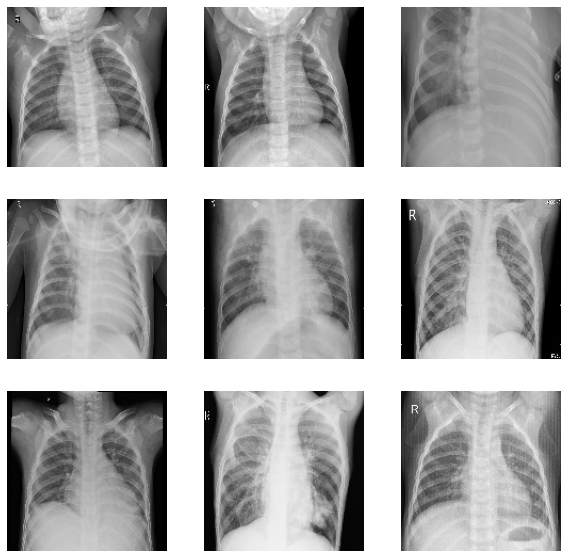

In [ ]:
# Menampilkan beberapa gambar untuk training
plt.figure(figsize=(10,10))
for i in range(1,10):
  plt.subplot(3,3,i)
  random_num = np.random.randint(0,len(X_train))
  plt.imshow(X_train[random_num][:,:,:])
  plt.grid(False)
  plt.axis('off')

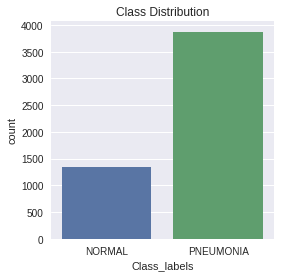

In [ ]:
# Distribusi kelas untuk dataset training
y_train_df = pd.DataFrame(y_train,columns=["Class_labels"])
plt.figure(figsize=(4,4))
plt.title("Class Distribution")
sns.countplot(x='Class_labels',data=y_train_df)
plt.show()

# **3. Data Preprocessing**

In [ ]:
#Membuat Seed untuk random noise
seed = 100
np.random.seed(seed)

## **a) Validation Split**

Memisahkan beberapa data untuk validasi, yang akan digunakan untuk memvalidasi model selama proses pelatihan.

In [ ]:
from sklearn.model_selection import train_test_split

valRatio = 0.1
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=valRatio, random_state=seed)

In [ ]:
print("Shape of train set",X_train.shape)
print("Shape of validation set",X_val.shape)
print("Shape of test set",X_test.shape)

Shape of train set (4694, 150, 150, 3)
Shape of validation set (522, 150, 150, 3)
Shape of test set (624, 150, 150, 3)


## **b) Normalization**

Normalisasi dilakukan pada Dataset untuk Menskalakan nilai-nilai dalam dalam Rentang [0,1]

Normalisasi dilakukan sebagai berikut:

x = (x - mnt) / (maks - mnt) ; dengan min=0 dan maks=255

In [ ]:
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

## **c) Data Augmentation**

Data Augmentasi digunakan untuk meningkatkan jumlah Data dengan cara memvariasikan posisi gambar, seperti rotasi gambar, memperbesar ukuran gambar dan menukar posisi gambar, Hal ini dilakukan untuk menghindari masalah Overfitting pada hasil training

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False, 
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False, 
        zca_whitening=False, 
        rotation_range = 30,  
        zoom_range = 0.2, 
        width_shift_range=0.1,  
        height_shift_range=0.1,  
        horizontal_flip = True,  
        vertical_flip=False)  

datagen.fit(X_train)

# **4. Model Building**

In [ ]:
from keras.layers import Input, Dense, Dropout, Flatten, Activation, MaxPool2D
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, SeparableConv2D
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop

from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler,ModelCheckpoint,EarlyStopping
from keras.utils import to_categorical

ImportError: ignored

In [ ]:
import tensorflow as tf

## **a) Building Model Architecture**

In [ ]:
# Parameter Yang Digunakan
input_shape = (150,150,3)

#LR bagusnya 0.001
learning_rate = 0.001

#Tunning BZ = jumlah data yang dipelajari 
batch_size = 64
 
#epoch 
epochs = 50

Alternatif Model CNN dengan 5 layer yang terdiri dari COnv2D, BatchNomalization, MaxPool2D

In [ ]:
# model = Sequential()
# model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,3)))
# model.add(BatchNormalization())
# model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

# model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
# model.add(Dropout(0.1))
# model.add(BatchNormalization())
# model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

# model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
# model.add(BatchNormalization())
# model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

# model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
# model.add(Dropout(0.2))
# model.add(BatchNormalization())
# model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

# model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
# model.add(Dropout(0.2))
# model.add(BatchNormalization())
# model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

# model.add(Flatten())
# model.add(Dense(units = 128 , activation = 'relu'))
# model.add(Dropout(0.2))
# model.add(Dense(units = 1 , activation = 'sigmoid'))
# model.compile(optimizer = "adam" , loss = 'binary_crossentropy' , metrics = ['accuracy'])

# model.summary()

# #Batch_Normalization diperhatikan lagi kalau ga perlu dihapus aja
# #Optimizer = adam

Alternatif Model CNN dengan 5 Layer yang terdiri dari Conv2D dan MaxPool2D

In [ ]:
model= tf.keras.models.Sequential([
                                   tf.keras.layers.Conv2D(16, (3,3), activation= 'relu', input_shape= (150, 150, 3)),
                                   tf.keras.layers.MaxPool2D(2,2),
                                   tf.keras.layers.Conv2D(32, (3,3), activation= 'relu'),
                                   tf.keras.layers.MaxPool2D(2,2),
                                   tf.keras.layers.Conv2D(64, (3,3), activation= 'relu'),
                                   tf.keras.layers.MaxPool2D(2,2),
                                   tf.keras.layers.Conv2D(128, (3,3), activation= 'relu'),
                                   tf.keras.layers.MaxPool2D(2,2),
                                   tf.keras.layers.Conv2D(128, (3,3), activation= 'relu'),
                                   tf.keras.layers.MaxPool2D(2,2),

                                   tf.keras.layers.Flatten(),
                                   tf.keras.layers.Dense(256, activation= 'relu'),
                                   tf.keras.layers.Dense(512, activation= 'relu'),
                                   tf.keras.layers.Dense(1, activation= 'sigmoid')
])
model.summary()
model.compile(optimizer= 'adam', loss= 'binary_crossentropy', metrics= ['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       7

## **b) Training the model**

Learning Rate berperan penting dalam meminimalkan Fungsi Biaya. Learning Rate adalah Langkah Descent yang diambil oleh Algoritma optimizer untuk membuat nilai konvergen 


In [ ]:
path = f"/content/drive/MyDrive/Colab Notebooks/dataset/model.h5"

checkpoint = ModelCheckpoint(path,
                                monitor="val_loss",
                                mode="min",
                                save_best_only = True,
                                verbose=1)

# earlystop = EarlyStopping(monitor = 'val_loss', 
#                               min_delta = 0, 
#                               patience = 4,
#                               verbose = 1,
#                               restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
                              patience = 2, verbose=1,
                              factor=0.3, min_lr=0.000001)

# callbacks = [checkpoint, earlystop, reduce_lr]
callbacks = [checkpoint,reduce_lr]

#early stop cari tau lagi

In [ ]:
history = model.fit(datagen.flow(X_train,y_train, batch_size = 32), 
                    epochs = 50, validation_data = datagen.flow(X_val, y_val),  
                    callbacks = callbacks)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 147 steps, validate for 17 steps
Epoch 1/50
146/147 [============================>.] - ETA: 0s - loss: 0.5933 - accuracy: 0.7362
Epoch 00001: val_loss improved from inf to 0.54307, saving model to /content/drive/MyDrive/Colab Notebooks/dataset/model.h5
147/147 [==============================] - 31s 212ms/step - loss: 0.5937 - accuracy: 0.7358 - val_loss: 0.5431 - val_accuracy: 0.7644
Epoch 2/50
146/147 [============================>.] - ETA: 0s - loss: 0.5124 - accuracy: 0.7613
Epoch 00002: val_loss improved from 0.54307 to 0.44213, saving model to /content/drive/MyDrive/Colab Notebooks/dataset/model.h5
147/147 [==============================] - 29s 199ms/step - loss: 0.5106 - accuracy: 0.7620 - val_loss: 0.4421 - val_accuracy: 0.8161
Epoch 3/50
146/147 [============================>.] - ETA: 0s - loss: 0.3704 - accuracy: 0.8389
Epoch 00003: val_loss improved from 0.44213 to 0.26855, saving model to /content/drive/MyDrive/Cola

# **5. Model Evaluation**

## **a) Plot grafik train vs validation**

In [ ]:
def plot_validation_curves(result):
  result = pd.DataFrame(result)
  fig, axs = plt.subplots(1,2)
  result[['loss','val_loss']].plot(figsize=(10, 3),ax=axs[0])
  axs[0].set_title('Train vs validation Loss')
  axs[0].set_xlabel('Epochs')
  axs[0].set_ylabel('Loss')
  result[['accuracy','val_accuracy']].plot(figsize=(10, 3),ax=axs[1])
  axs[1].set_title('Train vs validation Accuracy')
  axs[1].set_xlabel('Epochs')
  axs[1].set_ylabel('Accuracy')

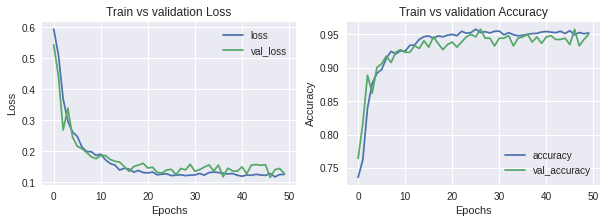

In [ ]:
plot_validation_curves(history.history)

## **b) Evaluasi model dari data tes** 

In [ ]:
predictions = model.predict_classes(X_test)
predictions = predictions.reshape(1,-1)[0]
predictions[:15]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix

def plot_summary(predictions):
 
  y_pred_classes = predictions
  print("***************** CLASSIFICATION  *****************")
  print(classification_report(y_test,y_pred_classes),"\n\n")
  print("******************* CONFUSION MATRIX *******************")
  plt.figure(figsize=(8,8))
  sns.heatmap(confusion_matrix(y_test,y_pred_classes),linewidths=.5,cmap="YlGnBu",annot=True,cbar=False,fmt='d')
  plt.show()

***************** CLASSIFICATION  *****************
              precision    recall  f1-score   support

           0       0.97      0.76      0.85       234
           1       0.87      0.98      0.93       390

    accuracy                           0.90       624
   macro avg       0.92      0.87      0.89       624
weighted avg       0.91      0.90      0.90       624
 


******************* CONFUSION MATRIX *******************


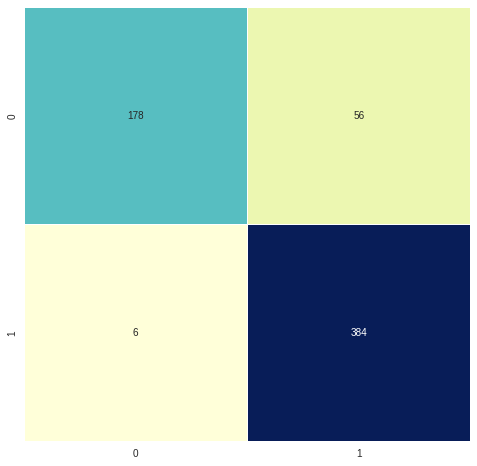

In [ ]:
plot_summary(predictions)

**1 : Pneumonia** <br>
**0 : Normal**

In [ ]:
model.save('cat_dogs/model_catsdogs.h5')